## Use Folder Dataset (for Custom Datasets) via API

Here we show how one can utilize custom datasets to train anomalib models. A custom dataset in this model can be of the following types:

- A dataset with good and bad images.
- A dataset with good and bad images as well as mask ground-truths for pixel-wise evaluation.
- A dataset with good and bad images that is already split into training and testing sets.

To experiment this setting we provide a toy dataset that could be downloaded from the following [https://github.com/openvinotoolkit/anomalib/blob/main/docs/source/data/hazelnut_toy.zip](link). For the rest of the tutorial, we assume that the dataset is downloaded and extracted to `../../datasets`, located in the `anomalib` directory.

### ! need to rerun next block after **first install**

In [1]:
!pip install anomalib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/openvinotoolkit/anomalib.git

Cloning into 'anomalib'...
remote: Enumerating objects: 22465, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 22465 (delta 85), reused 85 (delta 45), pack-reused 22325
Receiving objects: 100% (22465/22465), 52.64 MiB | 42.88 MiB/s, done.
Resolving deltas: 100% (13409/13409), done.


In [14]:
from pathlib import Path
from typing import Any, Dict

import numpy as np
from IPython.display import display
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

In [3]:
import numpy as np
from PIL import Image
from torchvision.transforms import ToPILImage

from anomalib.data.folder import Folder, FolderDataset
from anomalib.pre_processing import PreProcessor
from anomalib.pre_processing.transforms import Denormalize

from functools import partial, update_wrapper
from types import MethodType
from typing import Any

from matplotlib import pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.optim import Optimizer
from torch.optim.adam import Adam
from torch.utils.data import DataLoader

from anomalib.data import InferenceDataset
from anomalib.models.patchcore.lightning_model import Patchcore
from anomalib.post_processing import superimpose_anomaly_map
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import (
    ImageVisualizerCallback,
    MetricsConfigurationCallback,
    MetricVisualizerCallback,
    MinMaxNormalizationCallback,
)

In [4]:
# import the dataset from the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Torch Dataset

To create `FolderDataset` we need to import `pre_process` that applies transforms to the input image.

In [5]:
# get help command: PreProcessor??
pre_process = PreProcessor(image_size=256, to_tensor=True)

#### Classification Task

In [6]:
folder_dataset_classification_train = FolderDataset(
    normal_dir="/content/drive/MyDrive/hazelnut_toy/good",
    abnormal_dir="/content/drive/MyDrive/hazelnut_toy/colour",
    split="train",
    pre_process=pre_process,
)
folder_dataset_classification_train.samples.head()

,image_path,label,label_index,split
0,/content/drive/MyDrive/hazelnut_toy/good/00.jpg,normal,0,train
1,/content/drive/MyDrive/hazelnut_toy/good/01.jpg,normal,0,train
2,/content/drive/MyDrive/hazelnut_toy/good/02.jpg,normal,0,train
3,/content/drive/MyDrive/hazelnut_toy/good/03.jpg,normal,0,train
4,/content/drive/MyDrive/hazelnut_toy/good/04.jpg,normal,0,train


Let's look at the first sample in the dataset.

In [153]:
data = folder_dataset_classification_train[0]
data.keys(), data["image"].shape

(dict_keys(['image']), torch.Size([3, 256, 256]))

As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task

In [154]:
# Folder Classification Test Set
folder_dataset_classification_train = FolderDataset(
    normal_dir="/content/drive/MyDrive/hazelnut_toy/good",
    abnormal_dir="/content/drive/MyDrive/hazelnut_toy/colour",
    split="test",
    pre_process=pre_process,
)
folder_dataset_classification_train.samples.head()

,image_path,label,label_index,split
0,/content/drive/MyDrive/hazelnut_toy/good/02.jpg,normal,0,test
1,/content/drive/MyDrive/hazelnut_toy/good/06.jpg,normal,0,test
2,/content/drive/MyDrive/hazelnut_toy/good/09.jpg,normal,0,test
3,/content/drive/MyDrive/hazelnut_toy/good/19.jpg,normal,0,test
4,/content/drive/MyDrive/hazelnut_toy/good/23.jpg,normal,0,test


In [155]:
data = folder_dataset_classification_train[0]
data.keys(), data["image"].shape, data["image_path"], data["label"]

(dict_keys(['image', 'image_path', 'label']),
 torch.Size([3, 256, 256]),
 '/content/drive/MyDrive/hazelnut_toy/good/02.jpg',
 0)

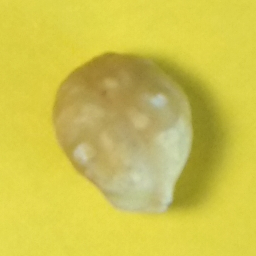

In [158]:
img = ToPILImage()(Denormalize()(data["image"].clone()))
#msk = ToPILImage()(data["mask"]).convert("RGB")

img

### DataModule

So far, we have shown the Torch Dataset implementation of Folder dataset. This is quite useful to get a sample. However, when we train models end-to-end fashion, we do need much more than this such as downloading the dataset, creating train/val/test/inference dataloaders. To handle all these, we have the PyTorch Lightning DataModule implementation, which is shown below

In [123]:
folder_datamodule = Folder(
    root="/content/drive/MyDrive/hazelnut_toy/",
    normal_dir="good",
    abnormal_dir="colour",
    task="classification",
    seed=20,
    #mask_dir="../../datasets/hazelnut_toy/mask/crack",
    image_size=256,
)
folder_datamodule.setup()

In [83]:
# Train images
i, data = next(enumerate(folder_datamodule.train_dataloader()))
data.keys(), data["image"].shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(dict_keys(['image']), torch.Size([28, 3, 256, 256]))

In [84]:
# Test images
i, data = next(enumerate(folder_datamodule.test_dataloader()))
data.keys(), data["image"].shape, data["label"].shape

(dict_keys(['image', 'image_path', 'label']),
 torch.Size([23, 3, 256, 256]),
 torch.Size([23]))

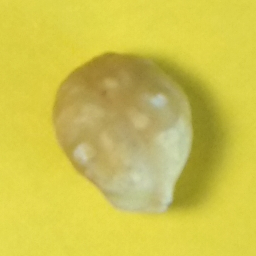

In [160]:
img = ToPILImage()(Denormalize()(data["image"].clone()))
#msk = ToPILImage()(data["crack"][0]).convert("RGB")

#Image.fromarray(np.hstack((np.array(img), np.array(msk))))
img

`Folder` data module offers much more flexibility cater all different sorts of needs. Please refer to the documentation for more details.

### MODEL

In [177]:
MODEL = "padim"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = f"/content/anomalib/anomalib/models/padim/hazelnut_config.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: folder #options: [mvtec, btech, folder]
  format: folder
  path: /content/drive/MyDrive/ped2
  task: classification
  normal_dir: ped2_train
  abnormal_dir: ped2_test
  normal_test_dir: null
  extensions: null
  split_ratio: 0.2
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  inference_batch_size: 32
  num_workers: 36
  transform_config:
    train: null
    val: null
  create_validation_set: true
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: stfpm
  backbone: resnet18
  layers:
    - layer1
    - layer2
    - layer3
  lr: 0.4
  momentum: 0.9
  weight_decay: 0.0001
  early_stopping:
    patience: 3
    metric: pixel_AUROC
    mode: max
  normalization_method: min_max # options: [null, min_max, cdf]

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC
  threshold:
    image_default: 0
    pixel_default: 0
    adap

In [172]:
config = get_configurable_parameters(config_path=CONFIG_PATH)

In [173]:
model = get_model(config)
callbacks = get_callbacks(config)

In [174]:
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=folder_datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch.

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
trainer.test(model=model, datamodule=folder_datamodule)

## PED2 DATASET

In [7]:
PED2_datamodule = Folder(
    root="/content/drive/MyDrive/ped2/",
    normal_dir="ped2_train",
    abnormal_dir="ped2_test",
    task="classification",
    seed=0,
    #mask_dir="../../datasets/hazelnut_toy/mask/crack",
    image_size=256,
)
PED2_datamodule.setup()

In [8]:
# Train images
i, data = next(enumerate(PED2_datamodule.train_dataloader()))
data.keys(), data["image"].shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(dict_keys(['image']), torch.Size([32, 3, 256, 256]))

In [9]:
# Test images
i, data = next(enumerate(PED2_datamodule.test_dataloader()))
data.keys(), data["image"].shape, data["label"].shape

(dict_keys(['image', 'image_path', 'label']),
 torch.Size([32, 3, 256, 256]),
 torch.Size([32]))

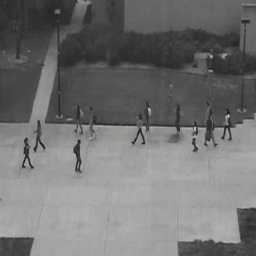

In [10]:
img = ToPILImage()(Denormalize()(data["image"][0].clone()))
img

## STFPM model

In [12]:
#MODEL2 = "padim"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH2 = f"/content/anomalib/anomalib/models/stfpm/custom_config.yaml"
with open(file=CONFIG_PATH2, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: folder #options: [mvtec, btech, folder]
  format: folder
  path: /content/drive/MyDrive/ped2
  task: classification
  normal_dir: ped2_train
  abnormal_dir: ped2_test
  normal_test_dir: null
  extensions: null
  split_ratio: 0.2
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  inference_batch_size: 32
  num_workers: 36
  transform_config:
    train: null
    val: null
  create_validation_set: true
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: stfpm
  backbone: resnet18
  layers:
    - layer1
    - layer2
    - layer3
  lr: 0.4
  momentum: 0.9
  weight_decay: 0.0001
  early_stopping:
    patience: 3
    metric: image_F1Score
    mode: max
  normalization_method: min_max # options: [null, min_max, cdf]

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC
  threshold:
    image_default: 0
    pixel_default: 0
    ad

In [15]:
config2 = get_configurable_parameters(config_path=CONFIG_PATH2)

In [16]:
model2 = get_model(config2)
callbacks2 = get_callbacks(config2)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
/usr/local/lib/python3.7/dist-packages/anomalib/utils/callbacks/__init__.py:133: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")


In [17]:
trainer2 = Trainer(**config2.trainer, callbacks=callbacks2)
trainer2.fit(model=model2, datamodule=PED2_datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch.

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [21]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer2.checkpoint_callback.best_model_path)
trainer2.callbacks.insert(0, load_model_callback)
trainer2.test(model=model2, datamodule=PED2_datamodule)

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9514074921607971
      image_F1Score         0.9464543461799622
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'image_F1Score': 0.9464543461799622, 'image_AUROC': 0.9514074921607971}]

In [23]:
image_filenames = list(Path(config2["project"]["path"]).glob("**/*.png"))
print(image_filenames[0])

/content/drive/MyDrive/results/ped2/stfpm/folder/images/image_ROC.png


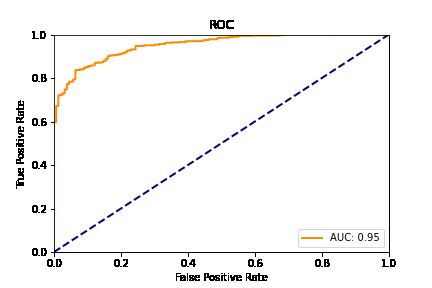

In [24]:
for filename in image_filenames:
    image = Image.open(filename)
    display(image)

# Inference

In [25]:
from anomalib.data import InferenceDataset

In [26]:
inference_dataset = InferenceDataset(
    path="/content/drive/MyDrive/ped2/ped2_test/02/101.jpg", image_size=(256, 256)
)
inference_dataloader = DataLoader(dataset=inference_dataset)

In [27]:
predictions = trainer2.predict(model=model2, dataloaders=inference_dataloader)[0]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Predicting: 20it [00:00, ?it/s]

In [28]:
print(predictions.keys())

dict_keys(['image', 'image_path', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks'])


In [29]:
print(
    f'Image Shape: {predictions["image"].shape},\n'
    'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)

Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: {predictions["anomaly_maps"].shape}, 
Predicted Mask Shape: {predictions["pred_masks"].shape}


In [31]:
image = predictions["image"][0]
image = Denormalize()(image)
print(f"Image Shape: {image.shape}\n Min Pixel: {image.min()} \n Max Pixel: {image.max()}")

Image Shape: (256, 256, 3)
 Min Pixel: 107 
 Max Pixel: 176


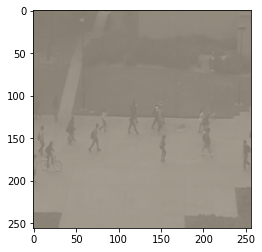

In [32]:
plt.imshow(image)

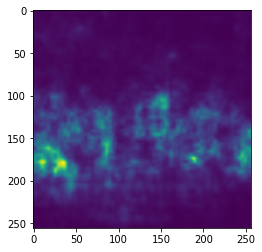

In [33]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)

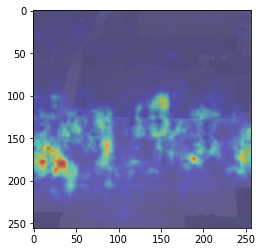

In [34]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)